<a href="https://colab.research.google.com/github/RaminParker/langchain_chrash_course/blob/main/Extract_Data_From_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Structured Data From Text: Expert Mode (Using Kor)
For complicated data extraction you need a robust library. The [Kor Library](https://eyurtsev.github.io/kor/tutorial.html) is an awesome tool just for this.


Why is this important? LLMs are great at text output, but they need extra help outputing information in a structure that we want.

Credits to this [YouTube video](https://www.youtube.com/watch?v=xZzvwR9jdPA). Code is [here](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/Expert%20Structured%20Output%20(Using%20Kor).ipynb)

In [ ]:
!pip install kor

In [ ]:
!pip -q install langchain openai

In [ ]:
!pip install markdownify

In [ ]:
# Kor!
from kor.extraction import create_extraction_chain
from kor.nodes import Object, Text, Number

# LangChain Models
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI

# Standard Helpers
import pandas as pd
import requests
import time
import json
from datetime import datetime

# Text Helpers
from bs4 import BeautifulSoup
from markdownify import markdownify as md

# For token counting
from langchain.callbacks import get_openai_callback

def printOutput(output):
    print(json.dumps(output,sort_keys=True, indent=3))

In [ ]:
# Mount your Google Drive on your Google Colab runtime
from google.colab import drive
drive.mount('/content/drive/')

path_to_key = "/content/drive/MyDrive/Colab Notebooks/configs/openai/token.txt" 
file1 = open(path_to_key, "r")
token_oai = file1.read()

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = token_oai

In [ ]:
# It's better to do this an environment variable but putting it in plain text for clarity
openai_api_key = token_oai

Let's start off by creating our LLM. We're using gpt4 to take advantage of its increased ability to follow instructions

In [ ]:
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo", # Cheaper but less reliable
    # model_name="gpt-4",       # https://platform.openai.com/docs/models/gpt-4
    temperature=0,
    max_tokens=2000,
    openai_api_key=openai_api_key
)

#Kor "Hello World" Example
Create an object that holds information about the fields you'd like to extract

In [ ]:
person_schema = Object(
    # This what will appear in your output. It's what the fields below will be nested under.
    # It should be the parent of the fields below. Usually it's singular (not plural)
    id="person",
    
    # Natural language description about your object
    description="Personal information about a person",
    
    # Fields you'd like to capture from a piece of text about your object.
    attributes=[
        Text(
            id="first_name",
            description="The first name of a person.",
        )
    ],
    
    # Examples help go a long way with telling the LLM what you need
    examples=[
        ("Alice and Bob are friends", [{"first_name": "Alice"}, {"first_name": "Bob"}])
    ]
)

Create a chain that will extract the information and then parse it. This uses LangChain under the hood

In [ ]:
chain = create_extraction_chain(llm, person_schema)

In [ ]:
text = """
    My name is Bobby.
    My sister's name is Rachel.
    My brother's name Joe. My dog's name is Spot
"""
output = chain.predict_and_parse(text=(text))["data"]

printOutput(output)
# Notice how there isn't "spot" in the results list because it's the name of a dog, not a person.

Using Kor you get None if the LLM doens't find what you are looking for

In [ ]:
output = chain.predict_and_parse(text=("The dog went to the park"))["data"]
printOutput(output)

# Multiple Fields to pull out of the text
You can pass multiple fields if you're looking for more information

In [ ]:
plant_schema = Object(
    id="plant",
    description="Information about a plant",
    
    # Notice I put multiple fields to pull out different attributes
    attributes=[
        Text(
            id="plant_type",
            description="The common name of the plant."
        ),
        Text(
            id="color",
            description="The color of the plant"
        ),
        Number(
            id="rating",
            description="The rating of the plant."
        )
    ],
    examples=[
        (
            "Roses are red, lilies are white and a 8 out of 10.",
            [
                {"plant_type": "Roses", "color": "red"},
                {"plant_type": "Lily", "color": "white", "rating" : 8},
            ],
        )
    ]
)

In [ ]:
text="Palm trees are brown with a 6 rating. Sequoia trees are green"

chain = create_extraction_chain(llm, plant_schema)
output = chain.predict_and_parse(text=text)['data']

printOutput(output)

# Working With Lists
You can also extract lists as well.

Note: Check out how I have a nested object. The 'parts' object is in the 'cars_schema'

In [ ]:
parts = Object(
    id="parts",
    description="A single part of a car",
    attributes=[
        Text(id="part", description="The name of the part")
    ],
    examples=[
        (
            "the jeep has wheels and windows",
            [
                {"part": "wheel"},
                {"part": "window"}
            ],
        )
    ]
)

In [ ]:
cars_schema = Object(
    id="car",
    description="Information about a car",
    examples=[
        (
            "the bmw is red and has an engine and steering wheel",
            [
                {"type": "BMW", "color": "red", "parts" : ["engine", "steering wheel"]}
            ],
        )
    ],
    attributes=[
        Text(
            id="type",
            description="The make or brand of the car"
        ),
        Text(
            id="color",
            description="The color of the car"
        ),
        parts
    ]
)

In [ ]:
# To do nested objects you need to specify encoder_or_encoder_class="json"
text = "The blue jeep has rear view mirror, roof, windshield"

# Changed the encoder to json
chain = create_extraction_chain(llm, cars_schema, encoder_or_encoder_class="json")
output = chain.predict_and_parse(text=text)['data']

printOutput(output)

View the prompt that was sent over

In [ ]:
prompt = chain.prompt.format_prompt(text=text).to_string()

print(prompt)

# Structuring user intent

Kor is a really great way to extract actions from a user as well

In [ ]:
schema = Object(
  id="forecaster",
  description=(
      "User is controling an app that makes financial forecasts. "
      "They will give a command to update a forecast in the future"
  ),
  attributes=[
      Text(
          id="year",
          description="Year the user wants to update",
          examples=[("please increase 2014's customers by 15%", "2014")],
          many=True,
      ),
      Text(
          id="metric",
          description="The unit or metric a user would like to influence",
          examples=[("please increase 2014's customers by 15%", "customers")],
          many=True,
      ),
      Text(
          id="amount",
          description="The quantity of a forecast adjustment",
          examples=[("please increase 2014's customers by 15%", ".15")],
          many=True,
      )
    ],
  many=False,
)

In [ ]:
chain = create_extraction_chain(llm, schema, encoder_or_encoder_class='json')
output = chain.predict_and_parse(text="please add 15 more units gold to 2023")['data']

printOutput(output)

# Extract the tools & technologies a company is using from their career page.

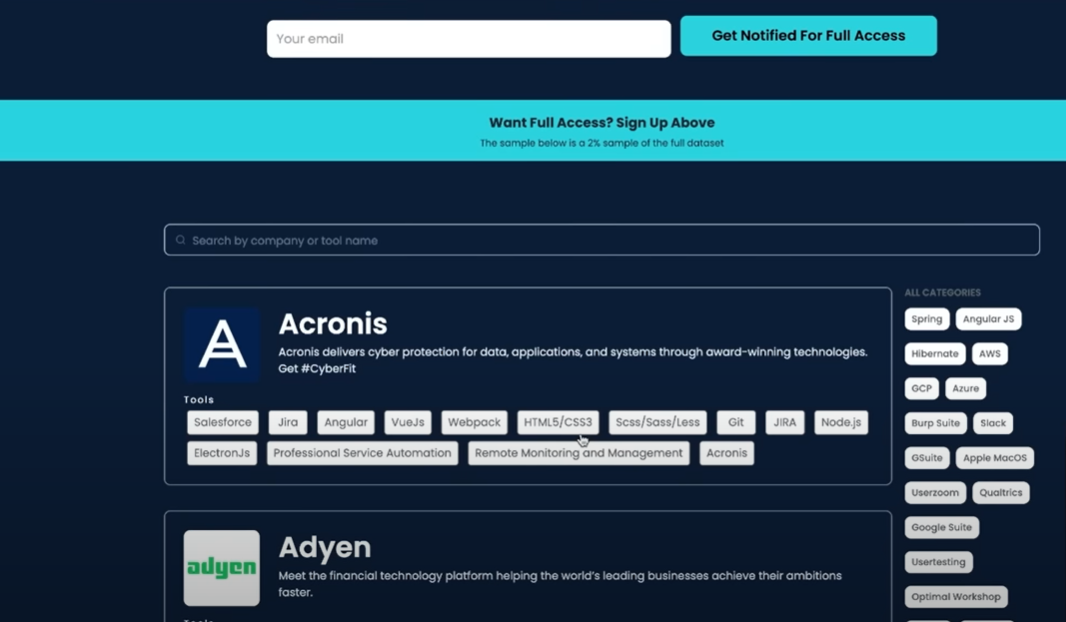

We are going to be pulling jobs from Greenhouse. No API key is needed.

In [ ]:
def pull_from_greenhouse(board_token):
    # If doing this in production, make sure you do retries and backoffs
    
    # Get your URL ready to accept a parameter
    url = f'https://boards-api.greenhouse.io/v1/boards/{board_token}/jobs?content=true'
    
    try:
        response = requests.get(url)
    except:
        # In case it doesn't work
        print ("Whoops, error")
        return
        
    status_code = response.status_code
    
    jobs = response.json()['jobs']
    
    print (f"{board_token}: {status_code}, Found {len(jobs)} jobs")
    
    return jobs

Let's try it out for [Okta](https://www.okta.com/).

In [ ]:
jobs = pull_from_greenhouse("okta")

Let's look at a sample job with it's raw dictionary

In [ ]:
# Keep in mind that my job_ids will likely change when you run this depending on the postings of the company
job_index = 0

In [ ]:
print("Preview:\n")
print(json.dumps(jobs[job_index])[:400])

Let's clean this up a bit

In [ ]:
# I parsed through an output to create the function below
def describeJob(job_description):
    print(f"Job ID: {job_description['id']}")
    print(f"Link: {job_description['absolute_url']}")
    print(f"Updated At: {datetime.fromisoformat(job_description['updated_at']).strftime('%B %-d, %Y')}")
    print(f"Title: {job_description['title']}\n")
    print(f"Content:\n{job_description['content'][:550]}")

We'll look at another job. This ``job_index`` may or may not work for you depending on if the position is still active.

In [ ]:
# Note: I'm using a hard coded job id below. You'll need to switch this if this job ever changes
# and it most definitely will!
job_id = 4982726

job_description = [item for item in jobs if item['id'] == job_id][0]
    
describeJob(job_description)

I want to convert the html to text, we'll use BeautifulSoup to do this. There are multiple methods you could choose from. Pick what's best for you.

In [ ]:
soup = BeautifulSoup(job_description['content'], 'html.parser')

In [ ]:
text = soup.get_text()

# Convert your html to markdown. This reduces tokens and noise
text = md(text)

print (text[:600])

Let's create a Kor object that will look for tools. This is the meat and potatoes of the application

In [ ]:
tools = Object(
    id="tools",
    description="""
        A tool, application, or other company that is listed in a job description.
        Analytics, eCommerce and GTM are not tools
    """,
    attributes=[
        Text(
            id="tool",
            description="The name of a tool or company"
        )
    ],
    examples=[
        (
            "Experience in working with Flask, or fastapi a plus.",
            [
                {"tool": "Flask"},
                {"tool": "fastapi"},
            ],
        ),
        (
           "Experience with Microsoft Excel",
            [
               {"tool": "Microsoft Excel"}
            ] 
        ),
        (
           "You must know AWS to do well in the job",
            [
               {"tool": "AWS"}
            ] 
        ),
        (
           "Troubleshooting customer issues and debugging from logs (Splunk, Syslogs, etc.) ",
            [
               {"tool": "Splunk"},
            ] 
        )
    ],
    many=True,
)

In [ ]:
chain = create_extraction_chain(llm, tools, input_formatter="triple_quotes")

In [ ]:
output = chain.predict_and_parse(text=text)["data"]

printOutput(output)

In [ ]:
with get_openai_callback() as cb:
    result = chain.predict_and_parse(text=text)
    print(f"Total Tokens: {cb.total_tokens}")
    print(f"Prompt Tokens: {cb.prompt_tokens}")
    print(f"Completion Tokens: {cb.completion_tokens}")
    print(f"Successful Requests: {cb.successful_requests}")
    print(f"Total Cost (USD): ${cb.total_cost}")